In [1]:
import os
import src

In [2]:
sheet = src.Sheet('samples/paraclis.pdf')

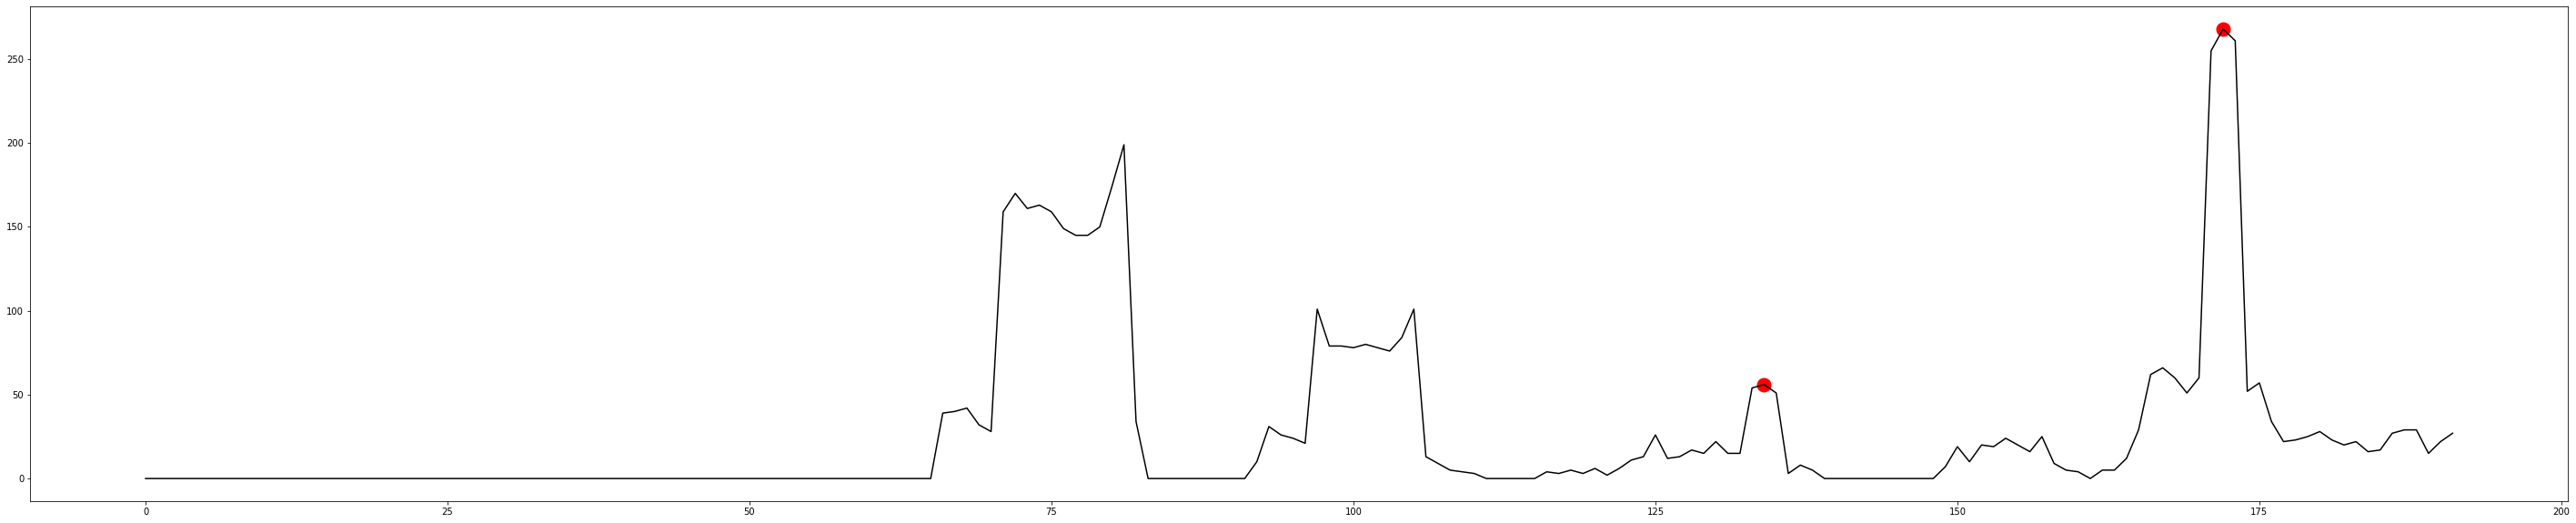

In [3]:
sheet[4].plot_raw_horizontal_projection()

['y = 134', 'y = 172', 'y = 235', 'y = 298', 'y = 361', 'y = 424', 'y = 487', 'y = 550', 'y = 613', 'y = 676', 'y = 739']
b1=y = 134
b2=y = 172
fst_pos=162 mid=153.0
b1=y = 172
b2=y = 235
fst_pos=212 mid=203.5
b1=y = 235
b2=y = 298
fst_pos=284 mid=266.5
b1=y = 298
b2=y = 361
fst_pos=354 mid=329.5
b1=y = 361
b2=y = 424
fst_pos=401 mid=392.5
b1=y = 424
b2=y = 487
fst_pos=479 mid=455.5
b1=y = 487
b2=y = 550
fst_pos=527 mid=518.5
b1=y = 550
b2=y = 613
fst_pos=591 mid=581.5
b1=y = 613
b2=y = 676
fst_pos=668 mid=644.5
b1=y = 676
b2=y = 739
fst_pos=732 mid=707.5


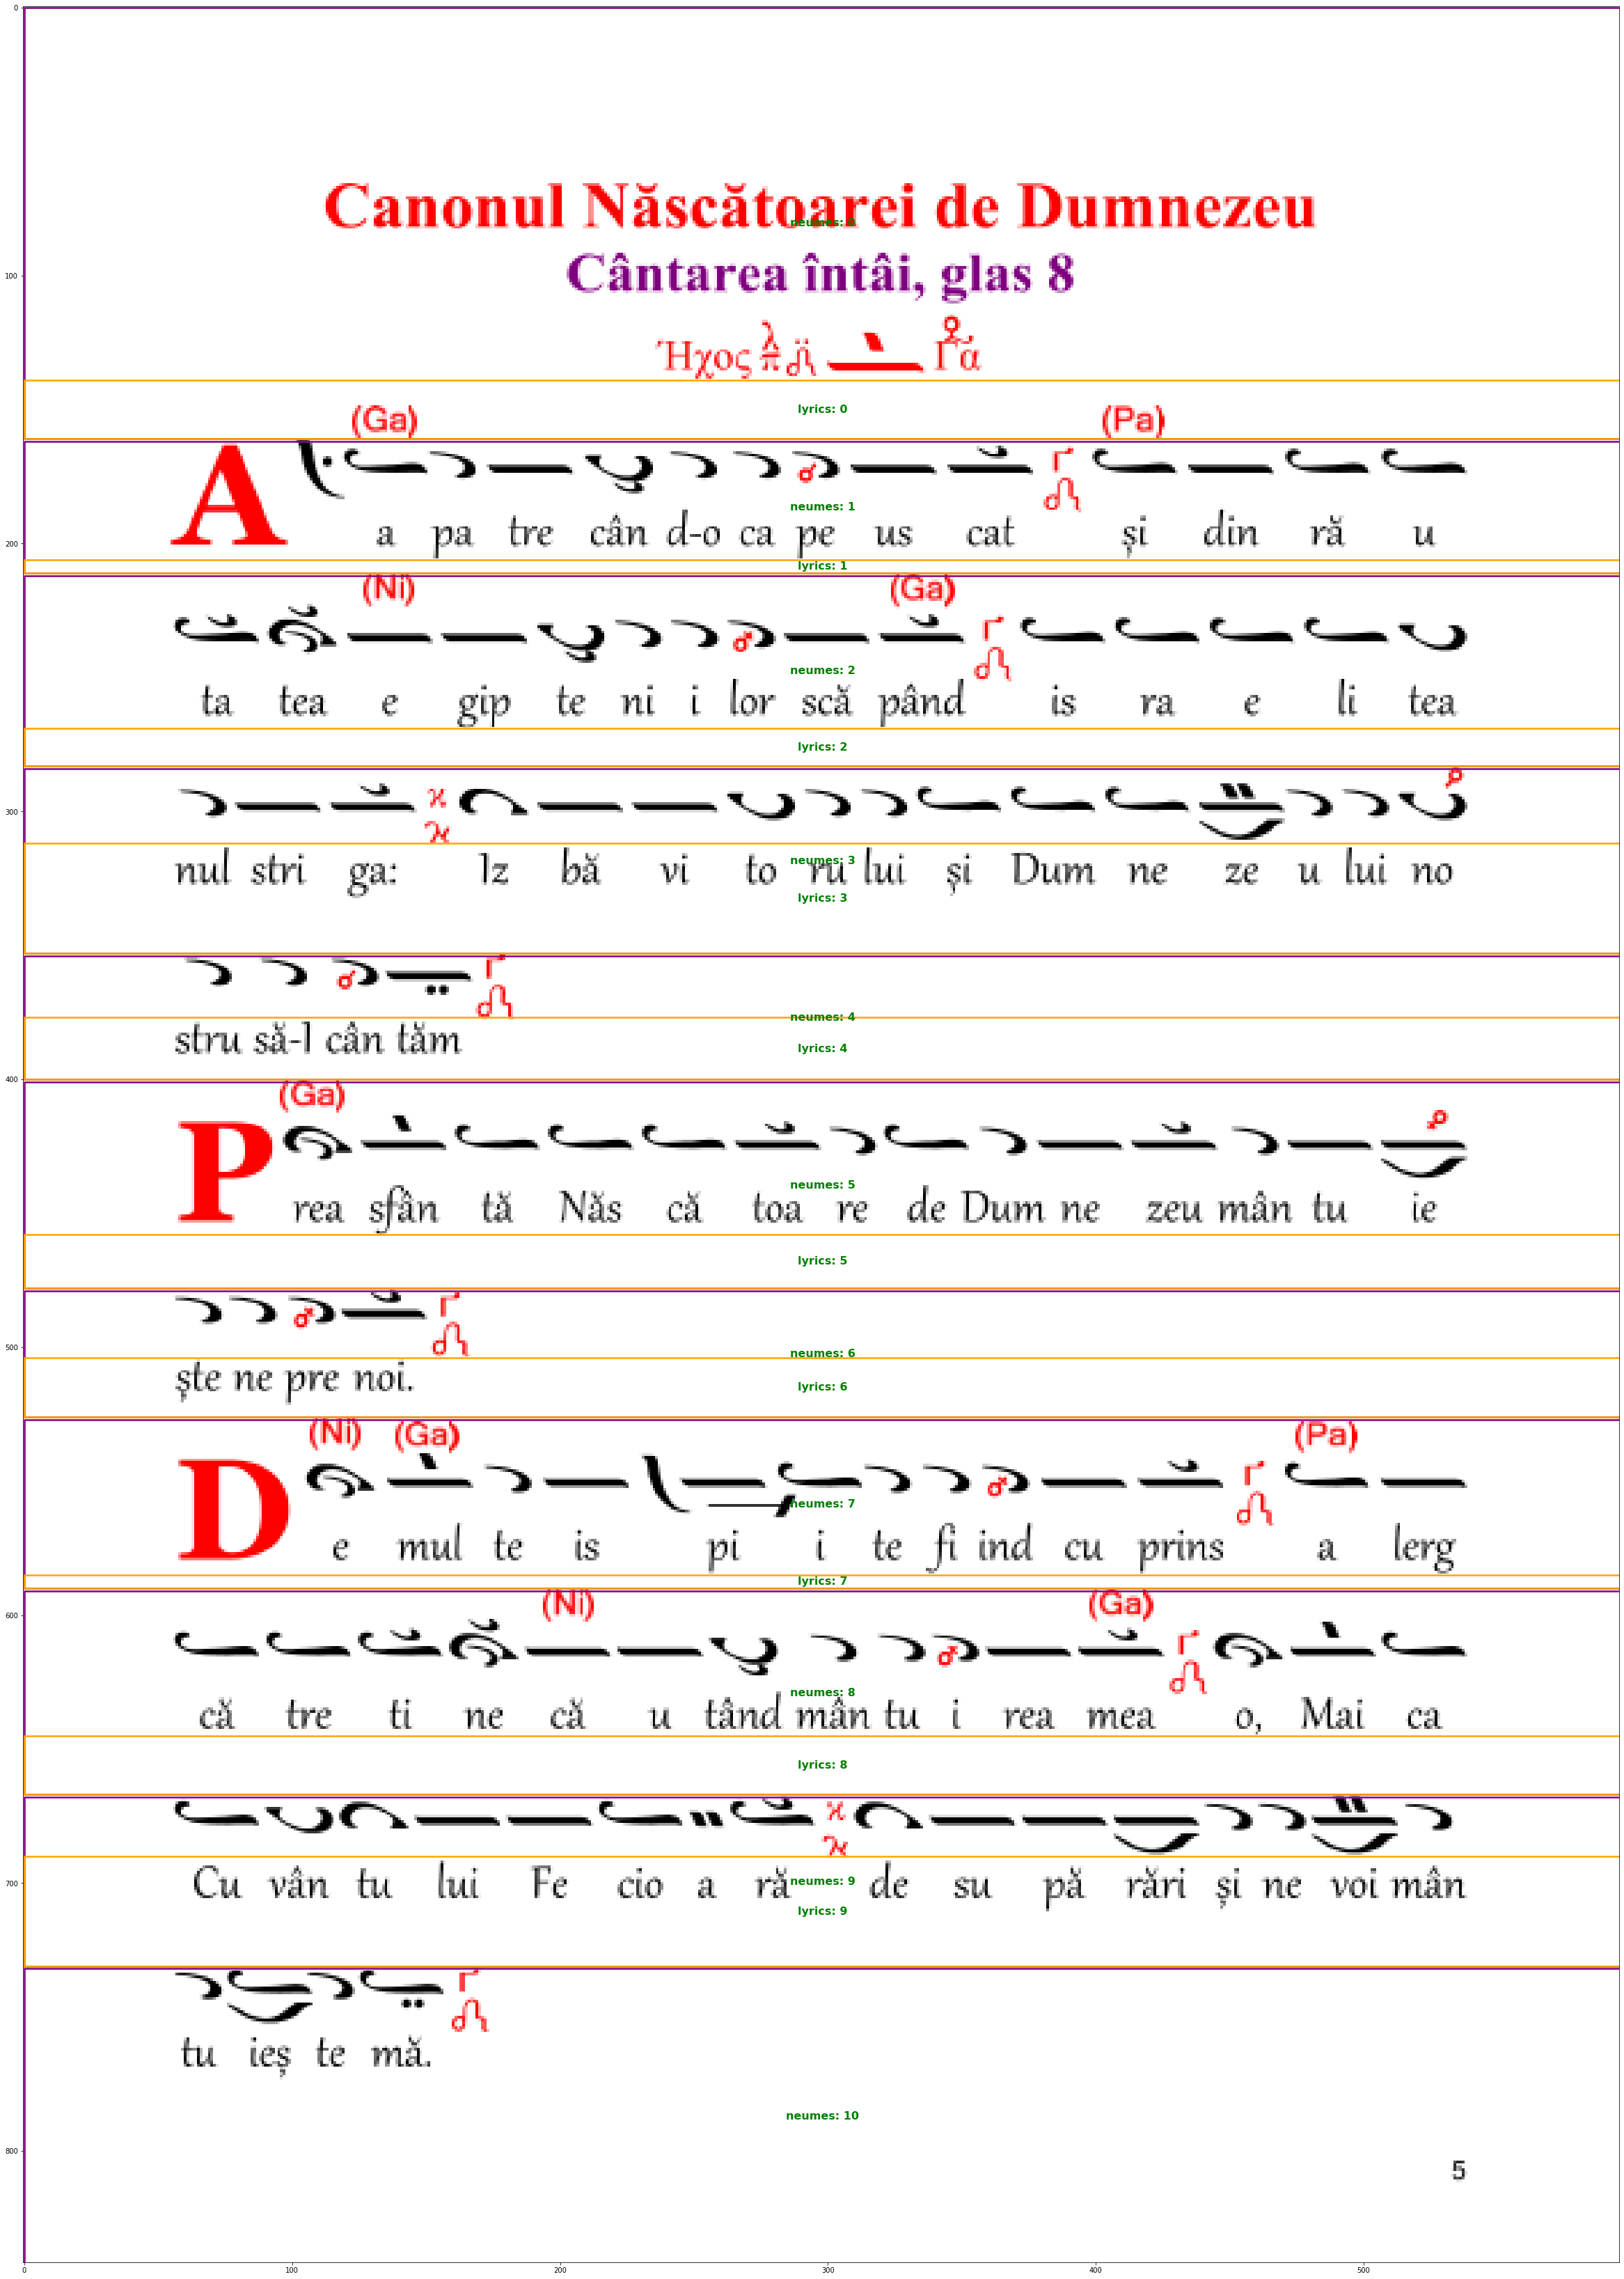

In [4]:
sheet[4].plot_full_baselines()

32


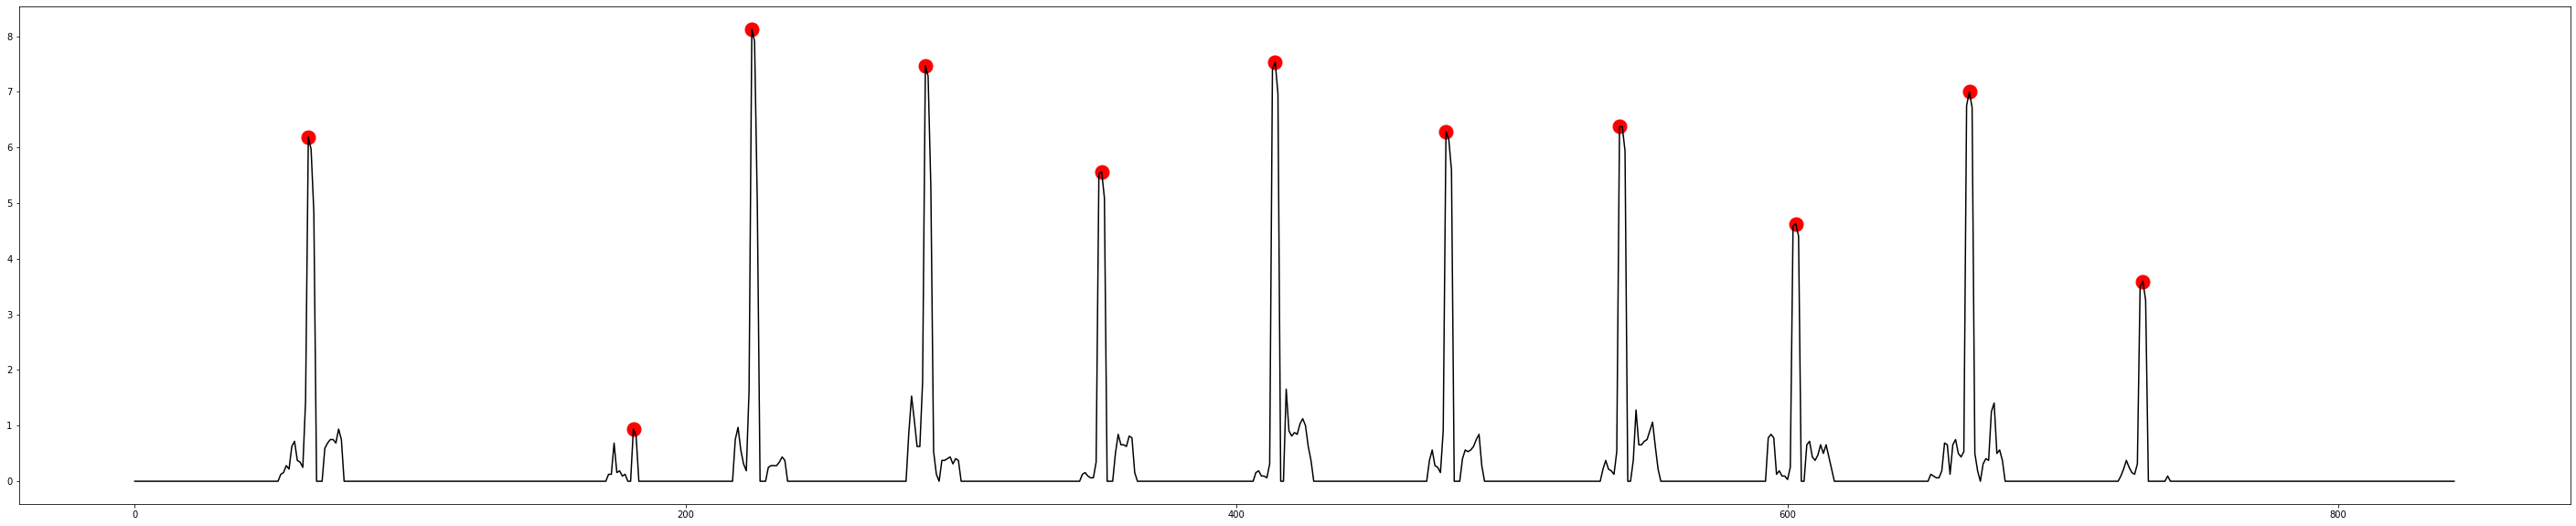

In [5]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

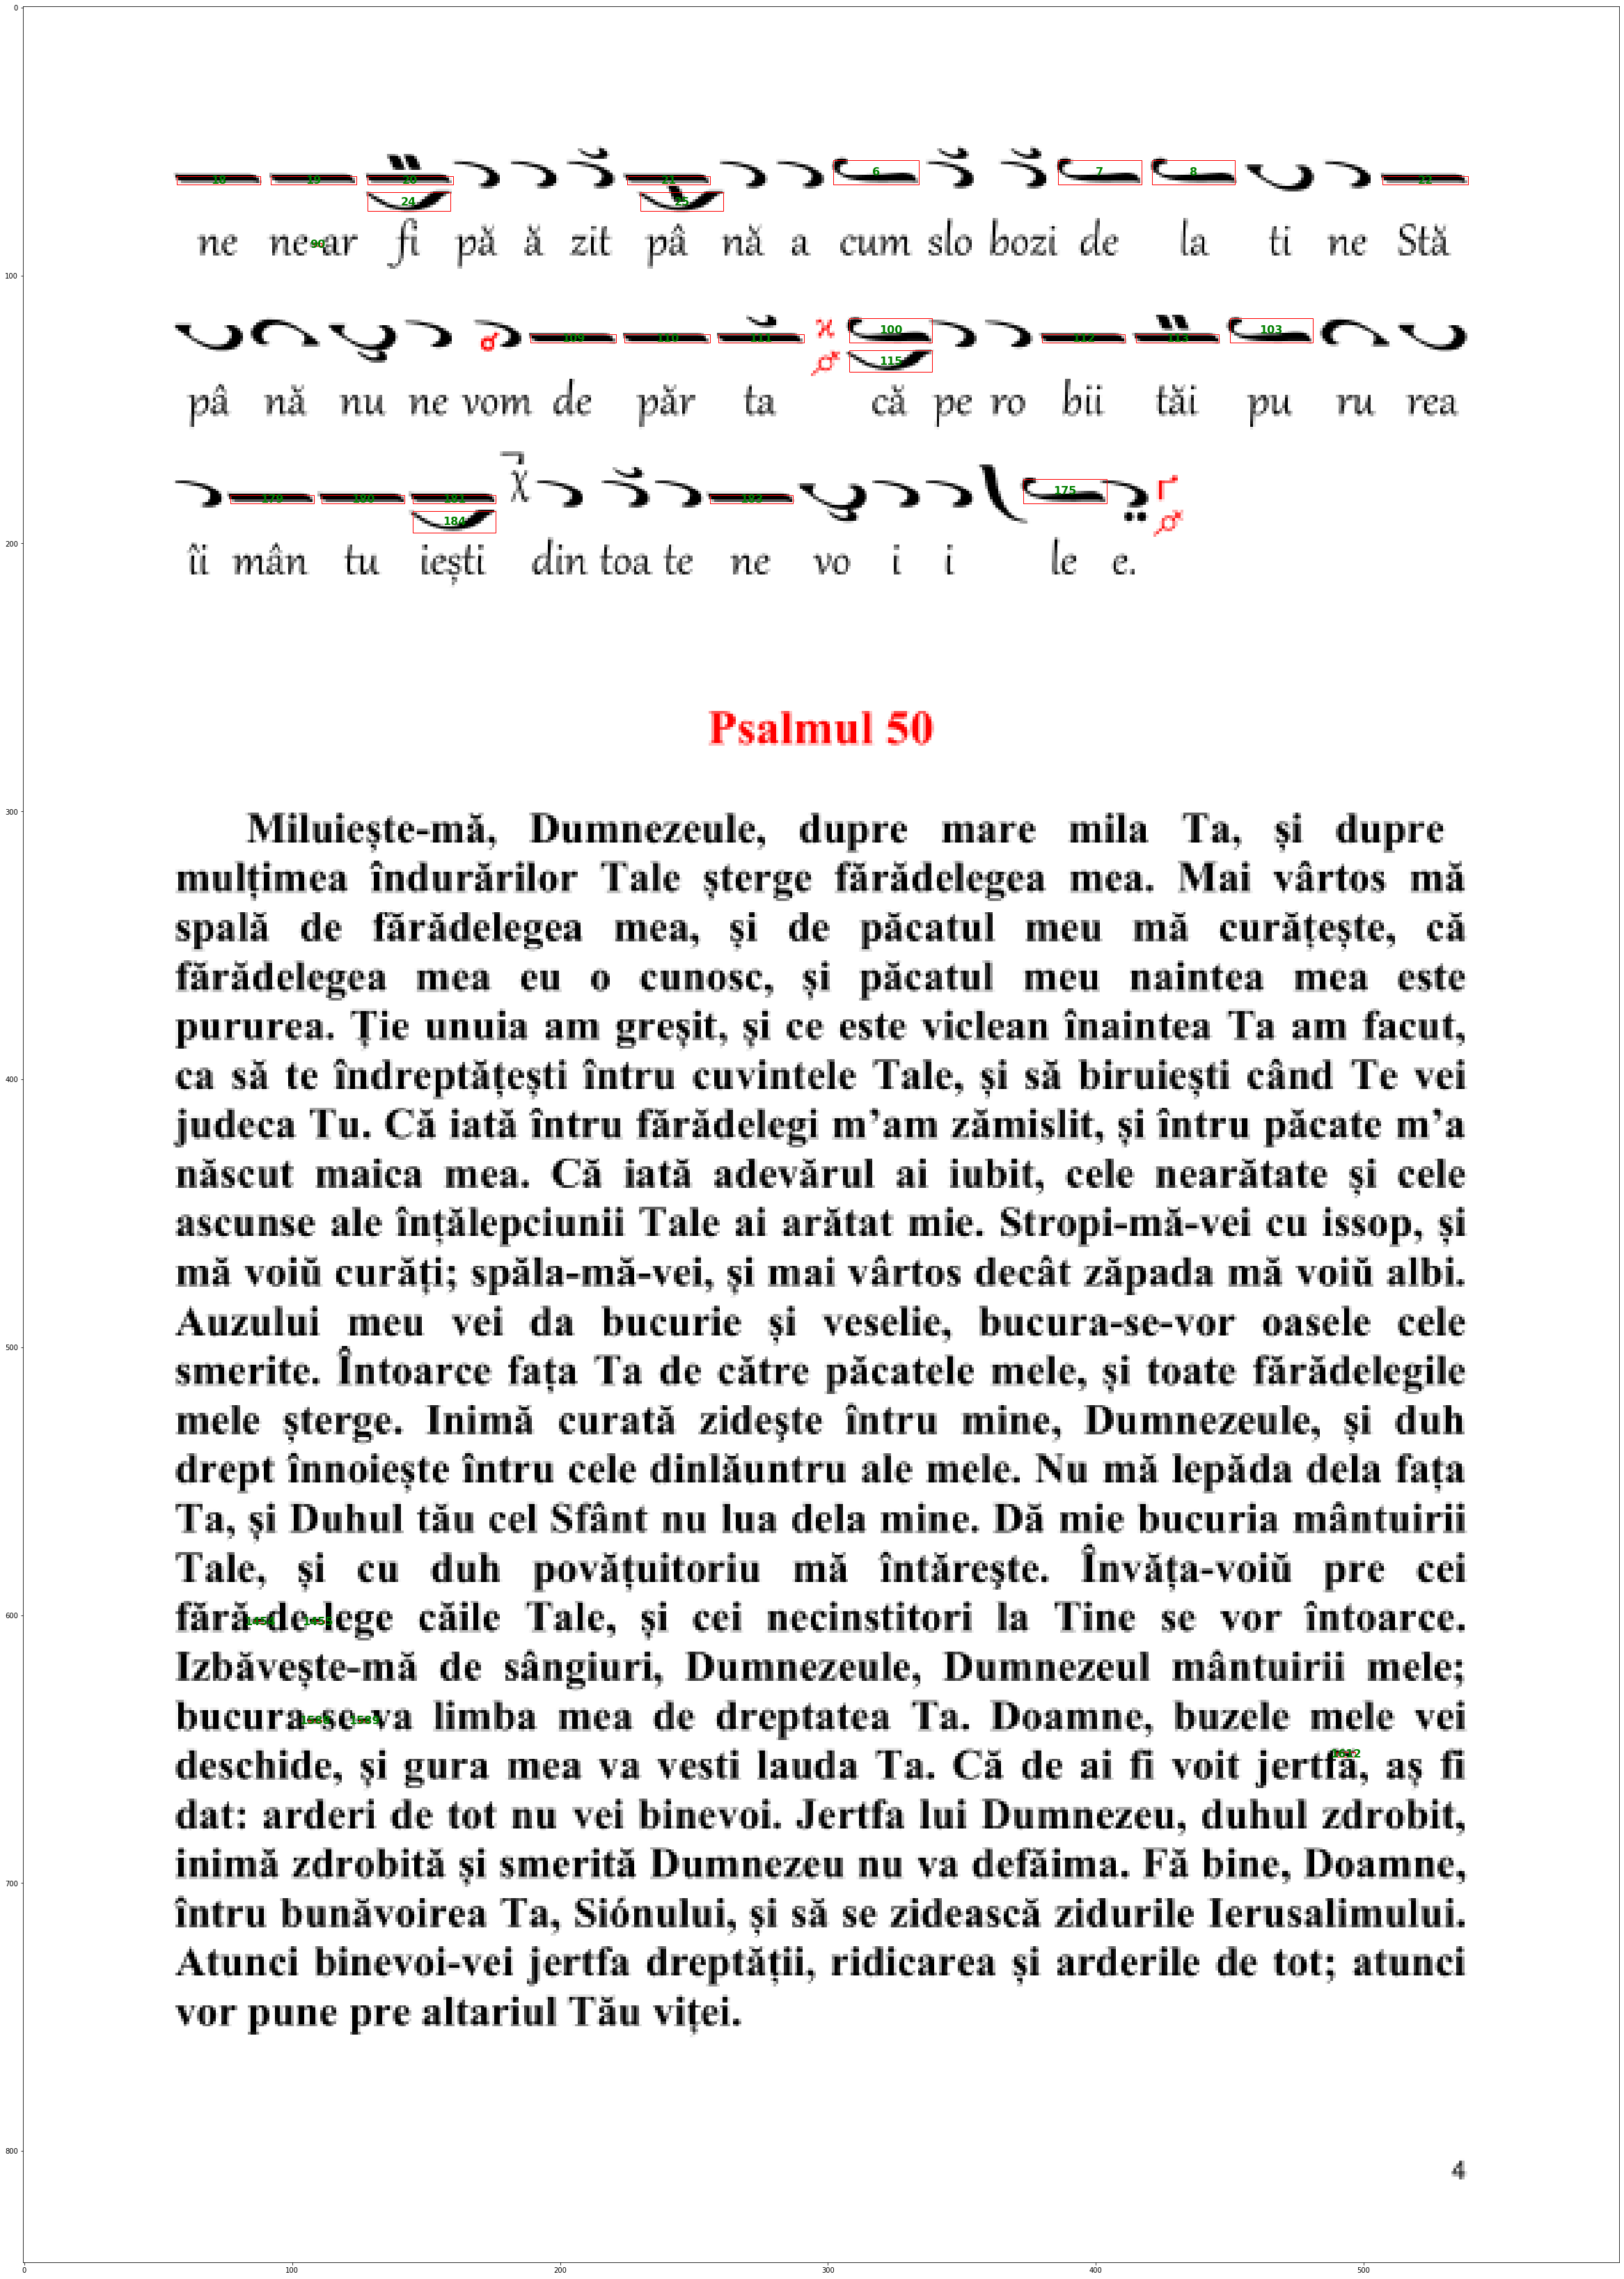

In [6]:
sheet[3].plot_ccs()